# Support Vector Machines: A Survey of its Applications with Special Emphasis on Facial Recognition Technology
> Introducing support vector machines while observing its use in the real world, with special consideration to facial recognition.

- toc: false
- branch: master
- badges: true
- comments: false
- math: true
- author: Kevin Le
- categories: [fastpages, jupyter]

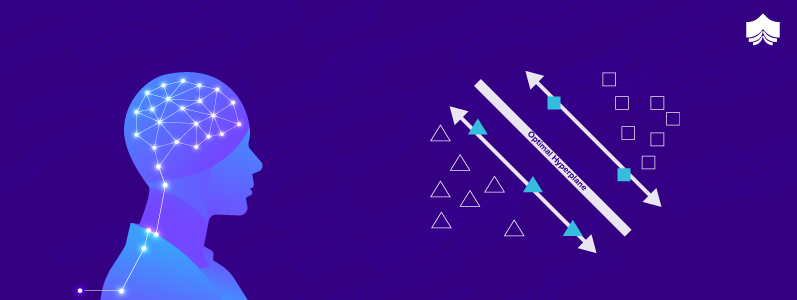

While some supervised machine learning models aim to draw numerical predictions given a set of features and target variable, other models aim to accurately classify data points to their corresponding labels given their features. These problems make up a vast subset of supervised machine learning problems, called classification problems. Several techniques, including logistic regression, decision tree classification, and others, are used to solve these problems. While the premise of classification problems is to determine a decision boundary that separates the data, each technique leverages different numerical properties of the data to discern these boundaries. In this article, we will be focusing on support vector machines, which use the data’s geometric properties to create a separating decision “slab”. More on that in a bit. 

At first glance, support vector machines sound like something you’d find in Tesla’s gigafactory, but they’re anything but that. We’ll be running through the (mathematical) mechanics of support vector machines, surveying its many applications, and examining the usage of support vector machines in facial recognition technology, along with its ethical considerations. 

## Introduction
This section will provide you everything you need to know about SVMs in a quick, but comprehensive manner before we explore how they’re applied in different contexts, especially in facial recognition.

### What are support vector machines? 
The support vector machine (SVM) is a supervised machine learning algorithm that can perform classification, regression, and outlier detection; however, we'll introduce the SVM with respect to binary classification, where we classify data points between two possible labels. Think of it almost like a yes or no problem! 

The overall premise of the SVM is to create the thickest separating decision slab that optimally separates the different classes of data. SVMs can create decision boundaries of different shapes, but we'll first focus on the linear SVM classifier. More specifically, let's start with hard-margin support vector machines. 

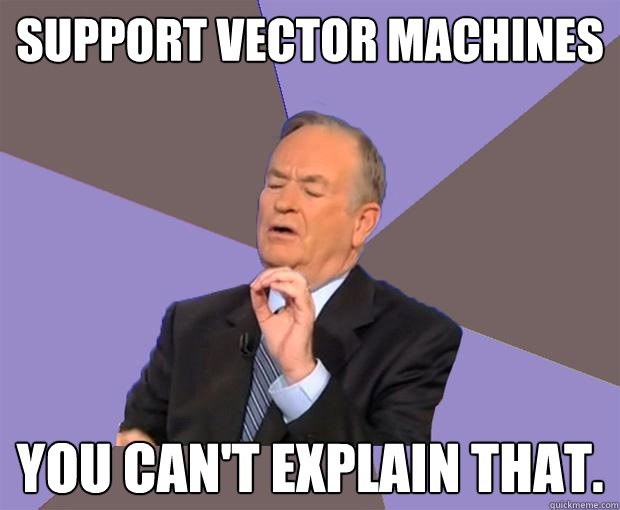

### Hard-margin SVM
Hard-margin SVM and linear SVM classifiers essentially go hand-in-hand. When using hard-margin SVMs, we want to find the widest linear decision boundary that separates the two classes of points. While this can sometimes be easily discerned by our visual cortex, if we wanted to draw a line between the points, there are actually an infinite number of possible lines to draw. That's where SVMs come into play. They determine the hyperplane that optimally separates the data. Think of our decision boundary as a separating slab, centered around a line that cuts through the space separating the classes of points. The visualization below, originally provided by [Samuel S. Watson, PhD](http://www.math.brown.edu/swatson2/index.html), provides visual intuition behind hard-margin SVMs. 

In [1]:
# hide
import Pkg;
Pkg.add("Plots")
Pkg.add("Distributions")
Pkg.add("JuMP")
Pkg.add("Ipopt")
Pkg.add("Random")

   Updating registry at `~/.julia/registries/General`
#########################################################                  79.4%############################### 100.0%
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
  Installed Ipopt_jll ─ v3.13.1+1
######################################################################### 100.0%
Updating `~/.julia/environments/v1.5/Project.toml`
  [b6b21f68] + Ipopt v0.6.3
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [ae81ac8f] + ASL_jll v0.1.1+4
  [b99e7846] + BinaryProvider v0.5.10
  [b6b21f68] + Ipopt v0.6.3
  [9cc047cb] + I

In [2]:
# hide
using Plots, Distributions, JuMP, Random
gr(fontfamily = "Palatino", size = (400,400), aspect_ratio = 1, legend = false);

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1278
┌ Info: Precompiling JuMP [4076af6c-e467-56ae-b986-b466b2749572]
└ @ Base loading.jl:1278


In [3]:
# hide
n = 20 
Random.seed!(123)
X = [randn(n) .- 4 randn(n) .+ 4
    randn(n) .+ 3 randn(n)]
y = repeat([1, -1], inner = n)
function original_scatter()
    scatter(X[:, 1], X[:, 2], group=y)
end

original_scatter (generic function with 1 method)

In [4]:
# hide 
(a, b), (c,d) = (-4.0, -2.4), (2.8, 7.7)
function add_line!()
    plot!([(a,b),(c,d)], linewidth = 1.5)
end

add_line! (generic function with 1 method)

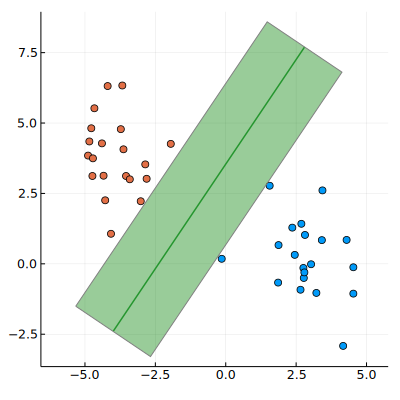

In [6]:
# hide_input
#Pkg.add("LinearAlgebra")
#using LinearAlgebra
function slab(a,b,c,d,w)
    v = [b-d, c-a]
    v *= w/norm(v)
    Tuple.([[a,b] + v, [c,d] + v, [c,d] - v, [a,b] - v, [a,b] + v])
end
function add_slab!()
    plot!(slab(a,b,c,d,1.6), fillopacity = 0.4, seriestype = :shape, fillcolor = :green, linecolor = :gray)
end
original_scatter()
add_line!()
add_slab!()

Mathematically, the slab represents the region between two parallel hyperplanes. The goal is to look for the thickest separating slab and choose the hyperplane in the middle as the decision boundary. Some points reside on the boundaries of the slab. These are **support vectors**, hence the name support vector machine. In essence, points that lie on one side of the slab will be classified as one label, and points that lie on the opposite side will be classified as another. 

Hard-margin SVMs determine the thickest separating slab between classes of points through **constrained optimization**. Suppose our observations are (x,y), where $y$ can assume the value of $+1$ or $-1$. Our separating slab can be described as ${x \in \mathbf{R^2}: -1 \leq \beta'\mathbf{x} + \alpha \leq 1}$, and the total width of the slab is $\frac{2}{|\beta|}$. We can check whether a point is on the correct side by evaluating whether $y_i (\beta \cdot x_i + \alpha) \geq 1$. This is the correct way of checking side membership. Let's say we have a point with label $-1$. If we were to multiply $-1$ by the value of the boundary closest to the cluster of $-1$ points, represented by $\beta \cdot x_i + \alpha = -1$, we'd obtain a positive number. The same principle applies to all $+1$ points.

To obtain the thickest slab, we need to minimize $\beta$, because $\beta$ is in the denominator for our equation for slab width. However, we subject our optimization to the constraint $y_i (\beta \cdot x_i + \alpha) \geq 1$. That is, we're looking for the widest separating slab such that all the points are still on the correct side. These are the general principles of hard-margin SVMs. 

In practice, not all data are so easily separable like the points given in our visualization. Therefore, we need to find a way to determine separating slabs in cases where the data aren't easily separable. Allow me to introduce the soft-margin SVM.

### Soft-margin SVM
Soft-margin SVMs overcome the problem of data inseparability by incurring a penalty term to all misclassified points. This penalty term is included in our loss function, which we will be trying to minimize in our pursuit for a separating slab. 

$$L(\beta,\alpha) = \lambda|\beta|^2 + \frac{1}{n}\sum_{i=1}^n [1 - y_i(\beta \cdot \mathbf{x_i} + \alpha]$$

We penalize by units of slab half-widths. All points on the midline get a penalty of 1 because they're one slab half-width away from the correct boundary, and so on. The parameter $\lambda$ mediates the tradeoff between maximizing slab width and the correcness incentive of the second. Soft-margin SVMs work better than hard-margin SVMs in datasets where points aren't easily separable because misclassified points are actually infinitely penalized in hard-margin SVMs. If we used hard-margin SVM to separate data points that weren't separable, we'd obtain an infinitesimally small separating slab.

### Kernelized SVM
Linear SVM classifiers are but one subset of support vector machines. Kernelized support vector machines allow us to create non-linear decision boundaries to better fit non-linear data. We do this by mapping feature vectors to a higher-dimensional space and finding a hyperplane that separates the data points in that space. For example, we can map data in $\mathbf{R^2}$ to a 3-dimensional space and determine a 2-dimensional hyperplane that separates the data. The image below, brought to you by [Drew Wilimitis](https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f), provides an intuitive visualization of what's commonly known as the **kernel trick**. 

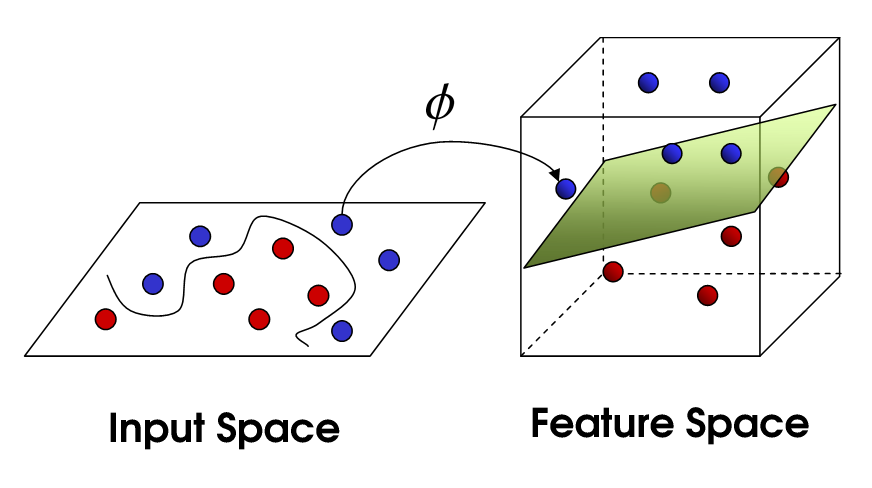

Given the input space, the data appear linearly inseparable, but after mapping through a mapping $\phi$ into a higher-dimensional space, the algorithm could determine a hyperplane that separates the data. The kernel $K$ is actually the dot product between the mappings of $\mathbf{x}$ and $\mathbf{y}$ vectors: $K = (\mathbf{x}, \mathbf{xy}) \mapsto \phi(x) \cdot \phi(y)$. Several types are kernels are commonly used in practice, including degree-d polynomial kernels, Gaussian radial basis function kernels, and sigmoid kernels.  

Now that we have the basic principles behind support vectors machines, let's explore some of the applications of SVMs in the real world. 

## Applications of Support Vector Machines
Support vector machines contain extremely desirable characteristics that make it a useful approach to classification problems. For one, they deal well with multi-dimensional data, often because the model returns sparse results and only really depends on a subset of points (the support vectors, et. al). SVMs also return a solution of a maximal margin, and convergence to the minimum for the loss function is guaranteed, given the convex optimization problem that arises when determining our separation slab. Not to mention, several experimental studies have demonstrated better classification accuracy and training times in SVMs, compared to other classification methods. 

The applications for SVMs span far and wide, so let's dive into it! 

### Text-based applications 
Hey Siri, how are SVMs used in text-based applications? Support vector machines are used in a multitude of text-based/speech-based applications, from spam detection, fraud detection, information retrieval for search engines, speech recognition, among many others. SVMs are well-equipped to deal with text/speech data because of the data's high dimensionality and linear separability. Documents of text are typically represented as a vector space with a dimension equal to the number of unique words in text after text preprocessing. 

In a text categorization study on a Reuters data base containing 21,578 documents and 118 categories, support vector machines outperformed Naive Bayes, Bayesian networks, decision trees, and k-nearest neighbors in terms of classification accuracy. SVMs continue to be a reliable model for text-based applications.  

### Bioinformatics 
With the advent of the Human Genome Project, biological data has faced an explosion in growth and availability. From genetic data to neurological data, the life sciences industry has had more data at their disposal than ever before. Ever since, there has been great interest in analysing biological samples using gene expression profiles. Some use cases for support vector machines include tissue classification, gene function prediction, protein secondary structure prediction, and protein fold prediction. An especially relevant application in bioinformatics is cancer recognition. These use cases are applicable to numerous subfields within the life sciences, from drug development to forensics. Many of these applications rely on methods used on image-based and text-based data, but they remain extremely important to life science research and the medical sector. 

### Geospatial data
SVMs are solid candidates for classification and prediction problems using geospatial data. Problems range from the calculation of the planets' density, to weather predictions. Generally, geospatial data, especially electromagnetic data, is quite noisy and delicate. Points are quite close to one another, so the data must utilize a method that prevents overfitting. Support vector machines are used to handle these datasets for this reason. 

These applications cover just the tip of the iceberg of possible applications of support vector machines. Although SVMs have been around since the late-20th century, it's no surprise that their usage is so broad. Support vector machines are incredibly versatile and reliable; one could be sure it'll *support* your supervised machine learning pipeline, if used correctly. 

Next, we'll be placing special attention to facial recognition technology, a technology that's had incredibly far-reaching impact in all corners of the world. Ubiquitous in today's society, we'll explore how facial recognition was first developed with SVMs and how it's evolved and used today. Facial recognition has not been without its fair share of controversy, so we'll be considering the ethical considerations of facial recognition technology as well. 

## Facial Recognition Technology
Have you ever wondered how Facebook could recognize your face in your mother's annual Christmas Facebook post? Ever wonder how it could recognize your friends and family in your photos? Ever thought about how Snapchat recognizes where to apply its filters when using your self-facing camera? The answers lie in facial recognition technology. Interestingly enough, support vector machines form the base of facial recognition technology applications. 

### SVMs and Facial Recognition

### Modern Facial Recognition Tech

### Ethical Considerations

### Lawsuits and Controversies